In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/train.csv
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test.csv
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/README.pdf
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/054.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/098.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/039.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/065.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/064.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/068.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/035.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/076.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/109.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/055.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/033.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/037.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image/005.dcm
/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/imag

In [2]:
# import libraries

# basic
import warnings
warnings.filterwarnings('ignore')

import os
import random
import pydicom
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

# visualization
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

# object detection
import json
from skimage.measure import label as sk_label
from skimage.measure import regionprops as sk_regions

In [3]:
class config:
    
    root = "/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8" ## your own base root path
    seed = 42

In [4]:
train_df = pd.read_csv("/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/train.csv", encoding='big5')
train_df

,ID,category,Width,Height,Filename,ImagePath,MarkPath
0,TDR04_20180315_075734,normal,2328,2344,220_97.dcm,/normal/image/220_97.dcm,/normal/mark/220_97.dcm.jpg
1,TDR04_20180315_080518,normal,2472,2560,220_94.dcm,/normal/image/220_94.dcm,/normal/mark/220_94.dcm.jpg
2,TDR04_20180315_081322,normal,2312,2496,220_93.dcm,/normal/image/220_93.dcm,/normal/mark/220_93.dcm.jpg
3,TDR04_20180315_081746,normal,2448,2584,220_92.dcm,/normal/image/220_92.dcm,/normal/mark/220_92.dcm.jpg
4,TDR04_20180315_082113,normal,2144,2384,220_91.dcm,/normal/image/220_91.dcm,/normal/mark/220_91.dcm.jpg
...,...,...,...,...,...,...,...
446,TDR02_20161209_161439,脊椎側彎,2376,2592,4440_5.dcm,/脊椎側彎/image/4440_5.dcm,/脊椎側彎/mark/4440_5.dcm.jpg
447,TDR04_20180224_084933,脊椎側彎,2248,2600,4440_0.dcm,/脊椎側彎/image/4440_0.dcm,/脊椎側彎/mark/4440_0.dcm.jpg
448,TDR04_20180226_082354,脊椎側彎,2488,2456,4440.dcm,/脊椎側彎/image/4440.dcm,/脊椎側彎/mark/4440.dcm.jpg
449,TDR01_20171106_095308,脊椎側彎,2320,2376,A0_29.dcm,/脊椎側彎/image/A0_29.dcm,/脊椎側彎/mark/A0_29.dcm.jpg


In [5]:
category = {
    "心臟肥大": "cardiac_hypertrophy",
    "主動脈硬鈣化": "aortic_atherosclerosis_calcification",
    "主動脈彎曲": "aortic_curvature",
    "肺尖肋膜增厚": "intercostal_pleural_thickening",
    "肺野浸潤增加": "lung_field_infiltration",
    "胸椎退化性關節病變": "degenerative_joint_disease_of_the_thoracic_spine",
    "脊椎側彎": "scoliosis",
    "normal": "normal"
}

In [6]:
def change_to_eng_names(df):
    
    df["category"] = df["category"].apply(lambda x: category[x])
    df["ImagePath"] = df.apply(lambda df: "/".join([df["category"], "image", df["Filename"]]), axis=1)
    df["MarkPath"] = df.apply(lambda df: "/".join([df["category"], "mark", df["Filename"] + ".jpg"]), axis=1)

change_to_eng_names(train_df)
train_df

,ID,category,Width,Height,Filename,ImagePath,MarkPath
0,TDR04_20180315_075734,normal,2328,2344,220_97.dcm,normal/image/220_97.dcm,normal/mark/220_97.dcm.jpg
1,TDR04_20180315_080518,normal,2472,2560,220_94.dcm,normal/image/220_94.dcm,normal/mark/220_94.dcm.jpg
2,TDR04_20180315_081322,normal,2312,2496,220_93.dcm,normal/image/220_93.dcm,normal/mark/220_93.dcm.jpg
3,TDR04_20180315_081746,normal,2448,2584,220_92.dcm,normal/image/220_92.dcm,normal/mark/220_92.dcm.jpg
4,TDR04_20180315_082113,normal,2144,2384,220_91.dcm,normal/image/220_91.dcm,normal/mark/220_91.dcm.jpg
...,...,...,...,...,...,...,...
446,TDR02_20161209_161439,scoliosis,2376,2592,4440_5.dcm,scoliosis/image/4440_5.dcm,scoliosis/mark/4440_5.dcm.jpg
447,TDR04_20180224_084933,scoliosis,2248,2600,4440_0.dcm,scoliosis/image/4440_0.dcm,scoliosis/mark/4440_0.dcm.jpg
448,TDR04_20180226_082354,scoliosis,2488,2456,4440.dcm,scoliosis/image/4440.dcm,scoliosis/mark/4440.dcm.jpg
449,TDR01_20171106_095308,scoliosis,2320,2376,A0_29.dcm,scoliosis/image/A0_29.dcm,scoliosis/mark/A0_29.dcm.jpg


In [7]:
temp = train_df[train_df["category"].duplicated() == False]
temp

,ID,category,Width,Height,Filename,ImagePath,MarkPath
0,TDR04_20180315_075734,normal,2328,2344,220_97.dcm,normal/image/220_97.dcm,normal/mark/220_97.dcm.jpg
80,TDR04_20180227_083423,aortic_curvature,2504,2536,220_14.dcm,aortic_curvature/image/220_14.dcm,aortic_curvature/mark/220_14.dcm.jpg
132,TDR01_20190313_090724,aortic_atherosclerosis_calcification,2392,2600,10_1d.dcm,aortic_atherosclerosis_calcification/image/10_...,aortic_atherosclerosis_calcification/mark/10_1...
203,TDR04_20180226_090403,cardiac_hypertrophy,2008,2280,4440.dcm,cardiac_hypertrophy/image/4440.dcm,cardiac_hypertrophy/mark/4440.dcm.jpg
236,TDR05_20151105_094209,intercostal_pleural_thickening,2296,2512,4440_4.dcm,intercostal_pleural_thickening/image/4440_4.dcm,intercostal_pleural_thickening/mark/4440_4.dcm...
265,TDR04_20180227_083423,lung_field_infiltration,2504,2536,220_3.dcm,lung_field_infiltration/image/220_3.dcm,lung_field_infiltration/mark/220_3.dcm.jpg
333,TDR04_20180227_085056,degenerative_joint_disease_of_the_thoracic_spine,2336,2360,220_15.dcm,degenerative_joint_disease_of_the_thoracic_spi...,degenerative_joint_disease_of_the_thoracic_spi...
393,TDR01_20171109_083459,scoliosis,2232,2408,A0_26.dcm,scoliosis/image/A0_26.dcm,scoliosis/mark/A0_26.dcm.jpg


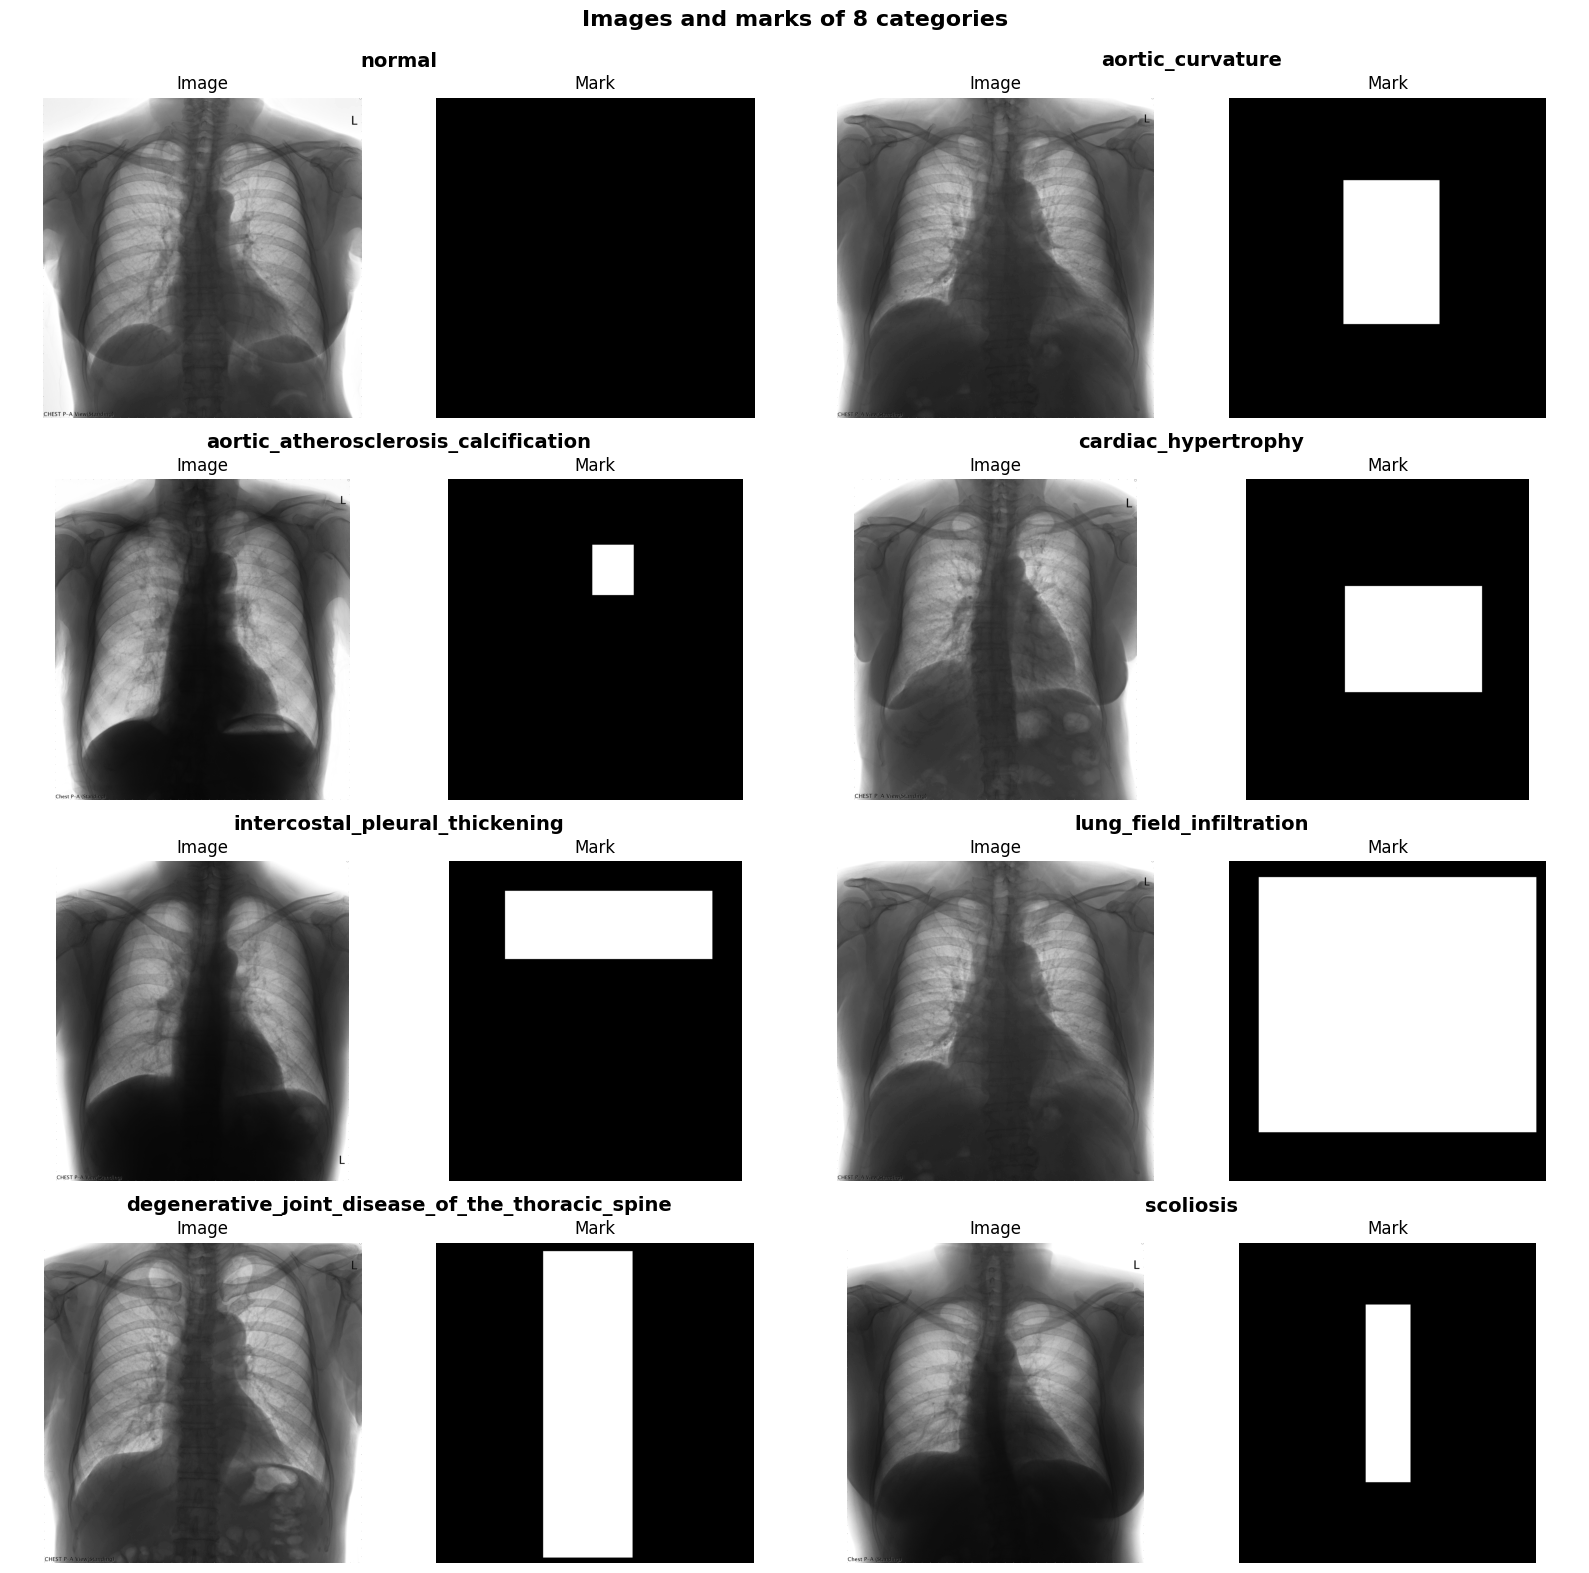

In [8]:
def plot_images_and_marks(df):
    
    temp = df[df["category"].duplicated() == False]
    
    rows, cols = 4, 2
    fig = plt.figure(figsize = (16, 16))
    grid = plt.GridSpec(rows, cols)
    
    for i in range(rows * cols):
        image = pydicom.dcmread(os.path.join(config.root, "train", temp.iloc[i, 5])).pixel_array
        if temp.iloc[i, 1] != "normal":
            mark = np.array(Image.open(os.path.join(config.root, "train", temp.iloc[i, 6])))
        else:
            mark = np.zeros((image.shape[0], image.shape[1]))
        
        categories = fig.add_subplot(grid[i])
        categories.set_title(f"{temp.iloc[i, 1]}\n", fontweight = 'semibold', size = 14)
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(image, cmap = "gray")
        ax.set_title("Image")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[1], sharey = ax)
        ax.imshow(mark, cmap = "gray")
        ax.set_title("Mark")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("Images and marks of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()
      
plot_images_and_marks(train_df)

In [9]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt


def X_ray_normalization(dcm_file, vmin=0, vmax=2.5):
    """
    讀取 DICOM 並對 X 光影像做：
      1) Intensity Log-Transformation
      2) Simplest Color Balance
    """
    ds = pydicom.dcmread(dcm_file)
    origin = ds.pixel_array.astype(float)

    
    WW = ds.WindowWidth
    WC = ds.WindowCenter
    BitsStored = ds.BitsStored

    
    if isinstance(WW, (list, tuple)):
        WW = WW[0]
    if isinstance(WC, (list, tuple)):
        WC = WC[0]

   
    iMin = WC - (WW / 2.0)
    iMax = WC + (WW / 2.0)

    
    clamped = np.clip(origin, iMin, iMax)

    
    log_img = -np.log((1.0 + clamped) / (2 ** BitsStored))

    
    normalize_img = (log_img - vmin) / (vmax - vmin)
    normalize_img = np.clip(normalize_img, 0.0, 1.0)

    return origin, log_img, normalize_img

<Figure size 1600x1600 with 0 Axes>

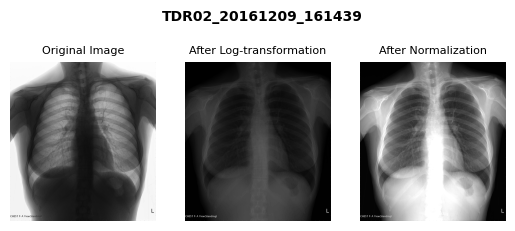

In [10]:
def plot_before_and_after(ID, df):
    
    patient_df = df[df["ID"] == ID]
    path = os.path.join(config.root, "train", patient_df.iloc[0, 5])
    origin, log_img, normalize_img = X_ray_normalization(path, vmin = 0, vmax = 2.5)
    
    plt.figure(figsize = (16, 16))
    fig, ax = plt.subplots(1, 3)
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    plt.subplots_adjust(wspace = None, hspace = None)
    
    ax[0].imshow(origin, cmap = "gray")
    ax[0].set_title("Original Image", size = 8)
    ax[1].imshow(log_img, cmap = "gray")
    ax[1].set_title("After Log-transformation", size = 8)
    ax[2].imshow(normalize_img, cmap = "gray")
    ax[2].set_title("After Normalization", size = 8)
          
    fig.suptitle(f"{ID}", fontweight = 'bold', size = 10, x = 0.52, y = 0.77)
    
plot_before_and_after(ID = "TDR02_20161209_161439", df = train_df)

In [11]:
def mask_to_bbox(mark_path):
    img = np.array(Image.open(mark_path))

    mask = img != 0
    sk_mask = sk_label(mask, connectivity = 2)
    regions = sk_regions(sk_mask)
    bboxes = []
    for region in regions:
        if region.area < 3000 :
            continue
        bboxes.append(region.bbox)

    ymin, xmin, ymax, xmax = bboxes[0]
    
    return xmin, ymin, xmax, ymax

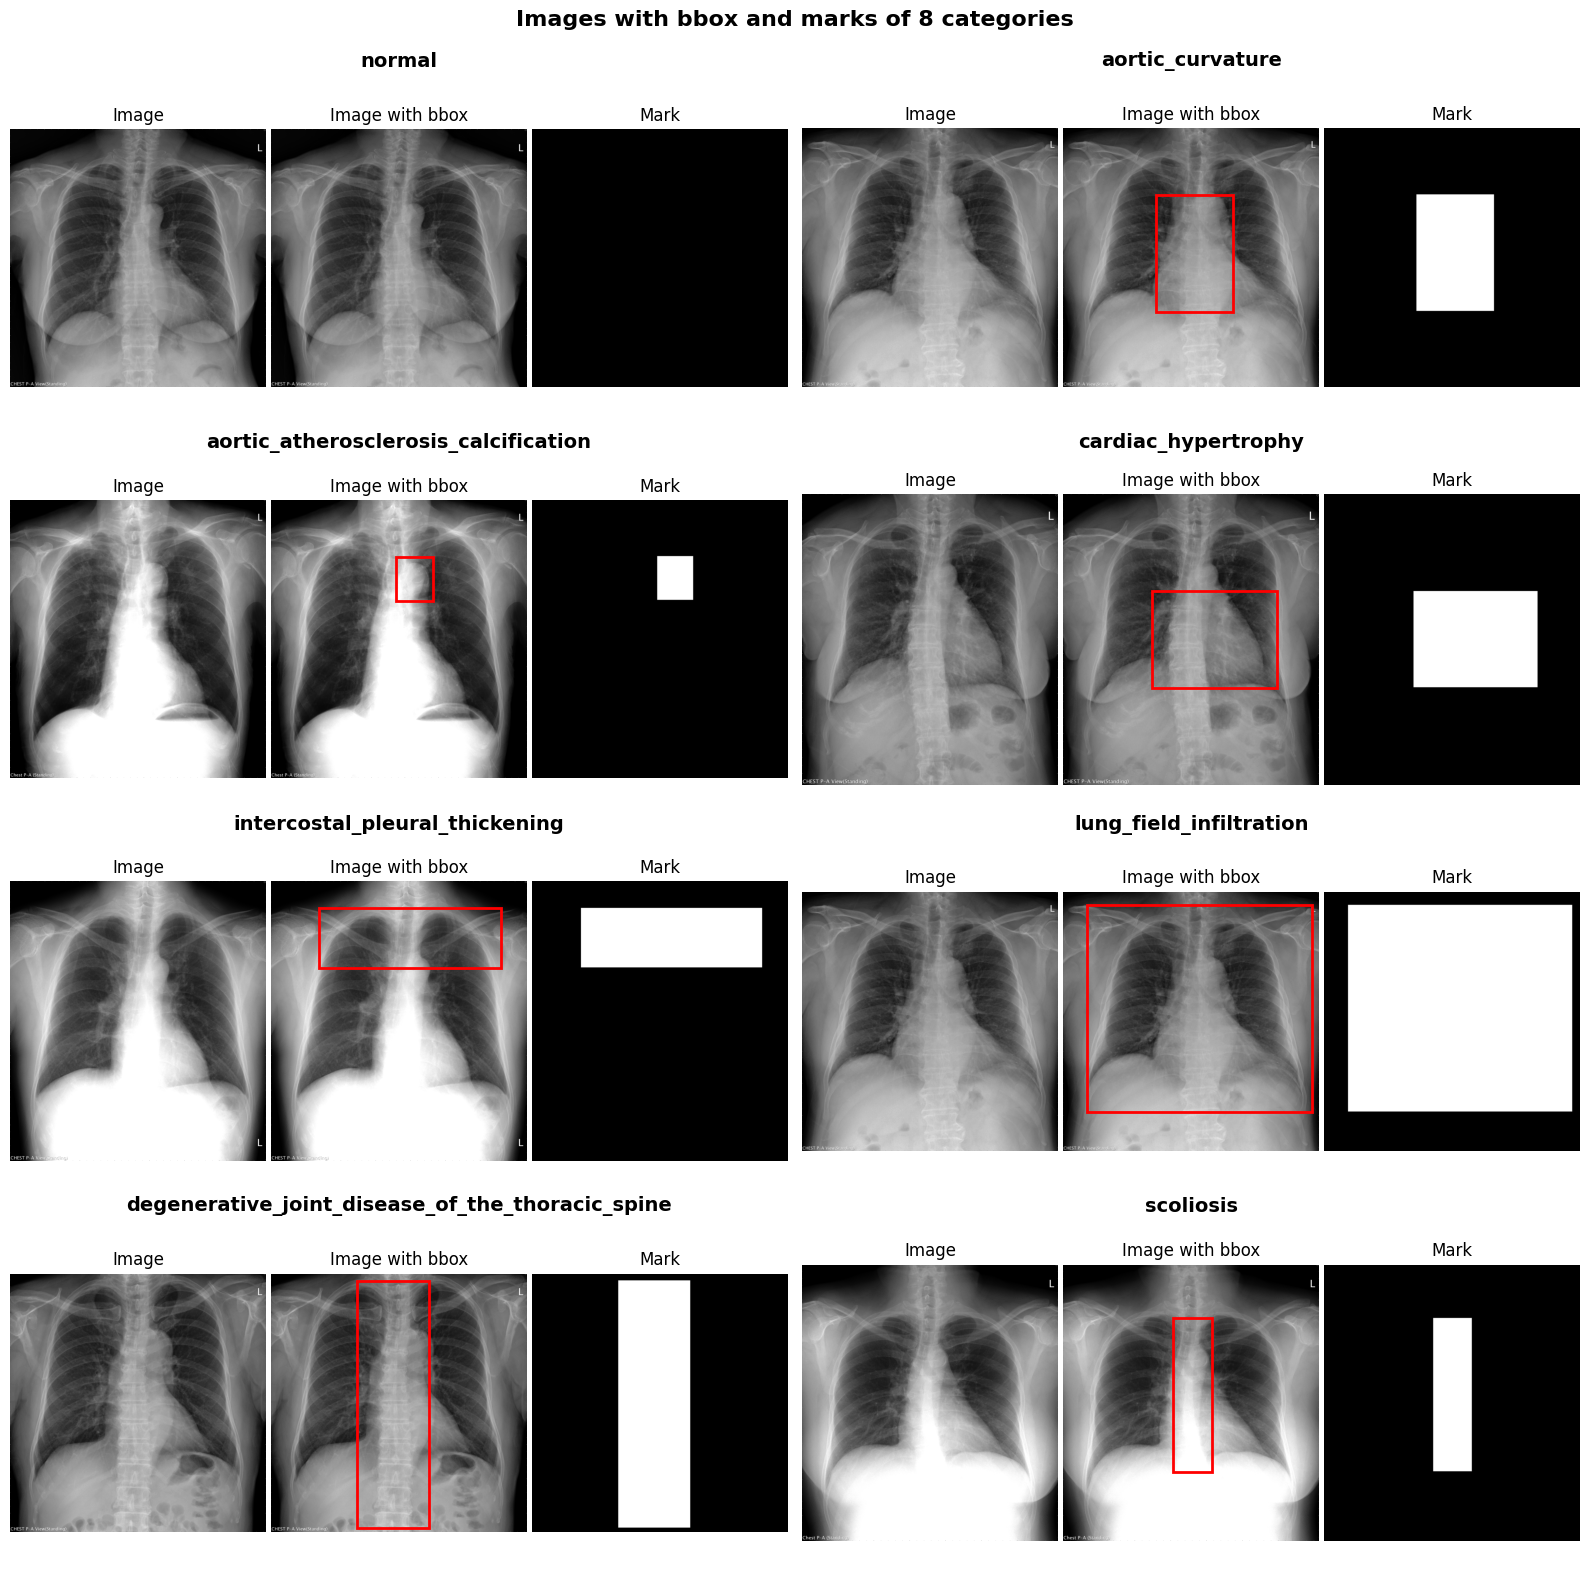

In [12]:
def plot_bbox_and_mark(df):
    
    temp = df[df["category"].duplicated() == False]
    
    rows, cols = 4, 2
    fig = plt.figure(figsize = (16, 16))
    grid = plt.GridSpec(rows, cols)
    
    for i in range(rows * cols):
        
        path = os.path.join(config.root, "train", temp.iloc[i, 5])
        mark_path = os.path.join(config.root, "train", temp.iloc[i, 6])
        
        _, _, after = X_ray_normalization(path, vmin = 0, vmax = 2.5)
        
        if temp.iloc[i, 1] != "normal":
            mark = np.array(Image.open(mark_path))
            xmin, ymin, xmax, ymax = mask_to_bbox(mark_path)
        else:
            mark = np.zeros((after.shape[0], after.shape[1]))
            xmin, ymin, xmax, ymax = 0, 0, 0, 0
        
        bbox = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth = 2, 
                                 edgecolor = "r", facecolor = 'none')
        
        categories = fig.add_subplot(grid[i])
        categories.set_title(f"{temp.iloc[i, 1]}\n", fontweight = 'semibold', size = 14)
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(after, cmap = "gray")
        ax.set_title("Image")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[1], sharey = ax)
        ax.imshow(after, cmap = "gray")
        ax.add_patch(bbox)
        ax.set_title("Image with bbox")
        ax.axis("off")
        
        ax = fig.add_subplot(gs[2], sharey = ax)
        ax.imshow(mark, cmap = "gray")
        ax.set_title("Mark")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("Images with bbox and marks of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()
      
plot_bbox_and_mark(train_df)

In [13]:
def write_bbox(df):
    
    all_xmin, all_ymin, all_xmax, all_ymax = [], [], [], []
    
    for i in range(df.shape[0]):
        
        if df.iloc[i, 1] != "normal":
            mark_path = os.path.join(config.root, "train", df.iloc[i, 6])
            xmin, ymin, xmax, ymax = mask_to_bbox(mark_path)
        else:
            xmin, ymin, xmax, ymax = 0, 0, 0, 0
        
        all_xmin.append(xmin)
        all_ymin.append(ymin)
        all_xmax.append(xmax)
        all_ymax.append(ymax)
        
    df["xmin"] = all_xmin
    df["ymin"] = all_ymin
    df["xmax"] = all_xmax
    df["ymax"] = all_ymax

write_bbox(train_df)
train_df

,ID,category,Width,Height,Filename,ImagePath,MarkPath,xmin,ymin,xmax,ymax
0,TDR04_20180315_075734,normal,2328,2344,220_97.dcm,normal/image/220_97.dcm,normal/mark/220_97.dcm.jpg,0,0,0,0
1,TDR04_20180315_080518,normal,2472,2560,220_94.dcm,normal/image/220_94.dcm,normal/mark/220_94.dcm.jpg,0,0,0,0
2,TDR04_20180315_081322,normal,2312,2496,220_93.dcm,normal/image/220_93.dcm,normal/mark/220_93.dcm.jpg,0,0,0,0
3,TDR04_20180315_081746,normal,2448,2584,220_92.dcm,normal/image/220_92.dcm,normal/mark/220_92.dcm.jpg,0,0,0,0
4,TDR04_20180315_082113,normal,2144,2384,220_91.dcm,normal/image/220_91.dcm,normal/mark/220_91.dcm.jpg,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
446,TDR02_20161209_161439,scoliosis,2376,2592,4440_5.dcm,scoliosis/image/4440_5.dcm,scoliosis/mark/4440_5.dcm.jpg,1016,560,1432,2328
447,TDR04_20180224_084933,scoliosis,2248,2600,4440_0.dcm,scoliosis/image/4440_0.dcm,scoliosis/mark/4440_0.dcm.jpg,912,552,1408,2272
448,TDR04_20180226_082354,scoliosis,2488,2456,4440.dcm,scoliosis/image/4440.dcm,scoliosis/mark/4440.dcm.jpg,1016,464,1560,2184
449,TDR01_20171106_095308,scoliosis,2320,2376,A0_29.dcm,scoliosis/image/A0_29.dcm,scoliosis/mark/A0_29.dcm.jpg,1032,512,1384,2016


In [14]:
labels = list(train_df["category"].unique())
label2class = {l: c for c, l in enumerate(labels)}
label2class

{'normal': 0,
 'aortic_curvature': 1,
 'aortic_atherosclerosis_calcification': 2,
 'cardiac_hypertrophy': 3,
 'intercostal_pleural_thickening': 4,
 'lung_field_infiltration': 5,
 'degenerative_joint_disease_of_the_thoracic_spine': 6,
 'scoliosis': 7}

In [15]:
def write_class_id(df):
    class_id = []
    for i in range(df.shape[0]):
        class_id.append(label2class[df.iloc[i, 1]])
    df["class_id"] = class_id
    
write_class_id(train_df)
train_df

,ID,category,Width,Height,Filename,ImagePath,MarkPath,xmin,ymin,xmax,ymax,class_id
0,TDR04_20180315_075734,normal,2328,2344,220_97.dcm,normal/image/220_97.dcm,normal/mark/220_97.dcm.jpg,0,0,0,0,0
1,TDR04_20180315_080518,normal,2472,2560,220_94.dcm,normal/image/220_94.dcm,normal/mark/220_94.dcm.jpg,0,0,0,0,0
2,TDR04_20180315_081322,normal,2312,2496,220_93.dcm,normal/image/220_93.dcm,normal/mark/220_93.dcm.jpg,0,0,0,0,0
3,TDR04_20180315_081746,normal,2448,2584,220_92.dcm,normal/image/220_92.dcm,normal/mark/220_92.dcm.jpg,0,0,0,0,0
4,TDR04_20180315_082113,normal,2144,2384,220_91.dcm,normal/image/220_91.dcm,normal/mark/220_91.dcm.jpg,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
446,TDR02_20161209_161439,scoliosis,2376,2592,4440_5.dcm,scoliosis/image/4440_5.dcm,scoliosis/mark/4440_5.dcm.jpg,1016,560,1432,2328,7
447,TDR04_20180224_084933,scoliosis,2248,2600,4440_0.dcm,scoliosis/image/4440_0.dcm,scoliosis/mark/4440_0.dcm.jpg,912,552,1408,2272,7
448,TDR04_20180226_082354,scoliosis,2488,2456,4440.dcm,scoliosis/image/4440.dcm,scoliosis/mark/4440.dcm.jpg,1016,464,1560,2184,7
449,TDR01_20171106_095308,scoliosis,2320,2376,A0_29.dcm,scoliosis/image/A0_29.dcm,scoliosis/mark/A0_29.dcm.jpg,1032,512,1384,2016,7


In [16]:
train_df.nunique()['ID'], train_df.shape[0]

(348, 451)

In [17]:
binarizer = MultiLabelBinarizer()
disease_id = []
for ID in train_df.ID.unique():
    diseases = []
    temp = train_df[train_df["ID"] == ID]
    diseases.extend(list(temp["class_id"]))
    disease_id.append(diseases)

one_hot = binarizer.fit_transform(disease_id)
one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [18]:
one_hot.shape

(348, 8)

In [19]:
train_ID, train_label, val_ID, val_label = iterative_train_test_split(np.expand_dims(train_df["ID"].unique(), axis = 1), one_hot, test_size = 0.2)

training = train_df[train_df["ID"].isin(train_ID.ravel())]
validation = train_df[train_df["ID"].isin(val_ID.ravel())]

In [20]:
categories = []
for l, c in label2class.items():
    if l == "normal":
        continue
    categories.append({"id": c, "name": l})

categories

[{'id': 1, 'name': 'aortic_curvature'},
 {'id': 2, 'name': 'aortic_atherosclerosis_calcification'},
 {'id': 3, 'name': 'cardiac_hypertrophy'},
 {'id': 4, 'name': 'intercostal_pleural_thickening'},
 {'id': 5, 'name': 'lung_field_infiltration'},
 {'id': 6, 'name': 'degenerative_joint_disease_of_the_thoracic_spine'},
 {'id': 7, 'name': 'scoliosis'}]

In [21]:
def coco_format(df, categories):
    coco_output = {
        "images" : [],
        "categories" : [],
        "annotations" : []
        }
 
    coco_output['categories'] = categories

    annotation_id = 0
    for image_id, img_name in enumerate(df.ID.unique()):
        image_df = df[df.ID == img_name]
        if len(image_df) == 1:
            image_dict = {
                "file_name" : list(image_df.category)[0] + "/" + list(image_df.Filename)[0].replace(".dcm", ".jpg"),
                "height" : int(image_df.Height),
                "width" : int(image_df.Width),
                "id" : image_id
                }
        else:
            unique = image_df.iloc[0, :]
            image_dict = {
                "file_name" : unique.category + "/" + unique.Filename.replace(".dcm", ".jpg"),
                "height" : int(unique.Height),
                "width" : int(unique.Width),
                "id" : image_id
                }  
        coco_output['images'].append(image_dict)

        for _, row in image_df.iterrows():
            xmin = int(row.xmin)
            ymin = int(row.ymin)
            xmax = int(row.xmax)
            ymax = int(row.ymax)
            if xmin == ymin == xmax == ymax == 0:
                continue

            area = (xmax - xmin) * (ymax - ymin)
          
            poly = [
                (xmin, ymin), (xmax, ymin), 
                (xmax, ymax), (xmin, ymax)
            ]
            poly = list(itertools.chain.from_iterable(poly))

            mask_dict = {
                "id" : annotation_id,
                "image_id" : image_id,
                "category_id" : row.class_id,
                "bbox" : [xmin, ymin, (xmax - xmin), (ymax - ymin)],
                "area" : area,
                "iscrowd" : 0, 
                "segmentation" : [poly],
                }
            coco_output["annotations"].append(mask_dict)
            annotation_id += 1

    return coco_output

In [22]:
train_coco = coco_format(training, categories)
val_coco = coco_format(validation, categories)

In [23]:
train_coco['images'][:5]

[{'file_name': 'normal/220_97.jpg', 'height': 2344, 'width': 2328, 'id': 0},
 {'file_name': 'normal/220_92.jpg', 'height': 2584, 'width': 2448, 'id': 1},
 {'file_name': 'normal/220_91.jpg', 'height': 2384, 'width': 2144, 'id': 2},
 {'file_name': 'normal/220_88.jpg', 'height': 2624, 'width': 2560, 'id': 3},
 {'file_name': 'normal/220_86.jpg', 'height': 2632, 'width': 2544, 'id': 4}]

In [24]:
train_coco['annotations'][:5]

[{'id': 0,
  'image_id': 64,
  'category_id': 1,
  'bbox': [904, 656, 760, 1143],
  'area': 868680,
  'iscrowd': 0,
  'segmentation': [[904, 656, 1664, 656, 1664, 1799, 904, 1799]]},
 {'id': 1,
  'image_id': 64,
  'category_id': 5,
  'bbox': [232, 128, 2200, 2024],
  'area': 4452800,
  'iscrowd': 0,
  'segmentation': [[232, 128, 2432, 128, 2432, 2152, 232, 2152]]},
 {'id': 2,
  'image_id': 65,
  'category_id': 1,
  'bbox': [872, 736, 632, 1072],
  'area': 677504,
  'iscrowd': 0,
  'segmentation': [[872, 736, 1504, 736, 1504, 1808, 872, 1808]]},
 {'id': 3,
  'image_id': 65,
  'category_id': 5,
  'bbox': [144, 280, 2168, 1952],
  'area': 4231936,
  'iscrowd': 0,
  'segmentation': [[144, 280, 2312, 280, 2312, 2232, 144, 2232]]},
 {'id': 4,
  'image_id': 66,
  'category_id': 1,
  'bbox': [1024, 528, 608, 1040],
  'area': 632320,
  'iscrowd': 0,
  'segmentation': [[1024, 528, 1632, 528, 1632, 1568, 1024, 1568]]}]

In [25]:
train_coco['categories']

[{'id': 1, 'name': 'aortic_curvature'},
 {'id': 2, 'name': 'aortic_atherosclerosis_calcification'},
 {'id': 3, 'name': 'cardiac_hypertrophy'},
 {'id': 4, 'name': 'intercostal_pleural_thickening'},
 {'id': 5, 'name': 'lung_field_infiltration'},
 {'id': 6, 'name': 'degenerative_joint_disease_of_the_thoracic_spine'},
 {'id': 7, 'name': 'scoliosis'}]

In [26]:
def dcm_to_jpg(df):
    
    for path in df.ImagePath:
        dcm_path = os.path.join(config.root, "train", path)
        _, _, image = X_ray_normalization(dcm_path, vmin = 0, vmax = 2.5)
        file = os.path.join("/kaggle/working/", path.split("/")[0])
        jpg_name = path.split("/")[-1].replace(".dcm", ".jpg")

        if os.path.isdir(file) == False:
            os.makedirs(file)

        plt.imsave(f"{file}/{jpg_name}", image, cmap = "gray")

In [27]:
def dcm_to_jpg_test(input_dir, output_dir):
    """
    將指定目錄中的 DICOM 檔案轉換成 JPEG。
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for dcm_file in os.listdir(input_dir):
        if dcm_file.endswith(".dcm"):
            dcm_path = os.path.join(input_dir, dcm_file)
            _, _, image = X_ray_normalization(dcm_path, vmin=0, vmax=2.5)

            jpg_name = dcm_file.replace(".dcm", ".jpg")
            output_path = os.path.join(output_dir, jpg_name)

            plt.imsave(output_path, image, cmap="gray")
            print(f"Saved: {output_path}")

# 設定路徑
input_test_dir = "/kaggle/input/dlmia-hw05-2/hwk05-csv-utf8/test/image"
output_test_dir = "/kaggle/working/test_images"

# 執行轉換
dcm_to_jpg_test(input_test_dir, output_test_dir)

Saved: /kaggle/working/test_images/054.jpg
Saved: /kaggle/working/test_images/098.jpg
Saved: /kaggle/working/test_images/039.jpg
Saved: /kaggle/working/test_images/065.jpg
Saved: /kaggle/working/test_images/064.jpg
Saved: /kaggle/working/test_images/068.jpg
Saved: /kaggle/working/test_images/035.jpg
Saved: /kaggle/working/test_images/076.jpg
Saved: /kaggle/working/test_images/109.jpg
Saved: /kaggle/working/test_images/055.jpg
Saved: /kaggle/working/test_images/033.jpg
Saved: /kaggle/working/test_images/037.jpg
Saved: /kaggle/working/test_images/005.jpg
Saved: /kaggle/working/test_images/032.jpg
Saved: /kaggle/working/test_images/063.jpg
Saved: /kaggle/working/test_images/095.jpg
Saved: /kaggle/working/test_images/088.jpg
Saved: /kaggle/working/test_images/110.jpg
Saved: /kaggle/working/test_images/013.jpg
Saved: /kaggle/working/test_images/103.jpg
Saved: /kaggle/working/test_images/072.jpg
Saved: /kaggle/working/test_images/113.jpg
Saved: /kaggle/working/test_images/092.jpg
Saved: /kag

In [29]:
import shutil 
shutil.make_archive("/kaggle/working/test_images", 'zip', "/kaggle/working/test_images")

'/kaggle/working/test_images.zip'